# clip 1000ms and copy file

In [25]:
from random import shuffle
import pandas as pd
import wave
import numpy as np
import matplotlib.pyplot as plt
import shutil
import os

PATH = "D:\sound_dataset\environment"
df = pd.read_csv("{}\meta\esc50.csv".format(PATH))
categorys  = df.drop_duplicates(subset=['category'])['category'].tolist()
df_vacuum_cleaner = df[(df['category'] == 'vacuum_cleaner')]
all_vacuum_cleaner = len(df_vacuum_cleaner)

src_file = df_vacuum_cleaner.drop_duplicates(subset=['src_file'])['src_file'].tolist()

vacuum_cleaner_dir = "{}\\vacuum_cleaner".format(PATH)
if not os.path.exists(vacuum_cleaner_dir):
    os.makedirs(vacuum_cleaner_dir)

for index, file_id in enumerate(src_file):
        rows = df.loc[df['src_file'] == file_id]
        for _, row in rows.iterrows():
            if (row['category'] == 'vacuum_cleaner'):
                # Init wave file info
                wav_obj = wave.open('{}\\audio\{}'.format(PATH, row['filename']), 'rb')
                sample_freq = wav_obj.getframerate()
                n_samples = wav_obj.getnframes()
                t_audio = n_samples/sample_freq 
                signal_wave = wav_obj.readframes(n_samples)
                waveform = np.frombuffer(signal_wave, dtype=np.int16)
                index = np.arange(sample_freq)[None, :] + np.arange(0, n_samples - sample_freq // 2, sample_freq)[:, None]
                data = waveform[index]
                for i in range(len(index)):
                    wav = wave.open('{}\\{}-{}.wav'.format(vacuum_cleaner_dir, row['filename'][:-4], i), "wb")
                    wav.setnchannels(wav_obj.getnchannels())
                    wav.setsampwidth(wav_obj.getsampwidth())    # Sample width: 16 bits
                    wav.setframerate(wav_obj.getframerate())    # Sample rate: 16kHz
                    audio = (data[i]).astype("<H")
                    wav.writeframes(audio.tobytes())
                    wav.close()

(49, 43)
1818.wav


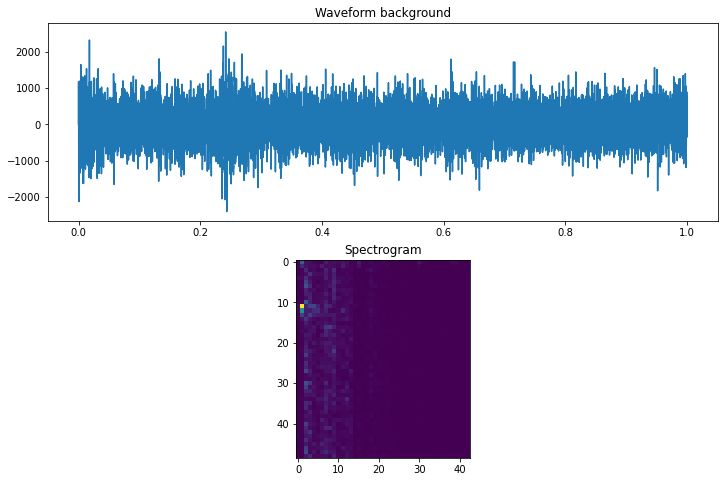

(49, 43)
nine_1b4c9b89_nohash_2.wav.wav


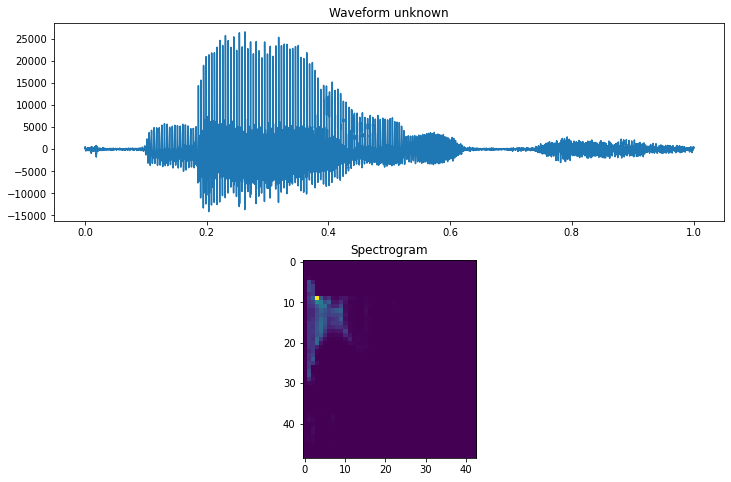

(49, 41)
2-141682-A-36-2.wav


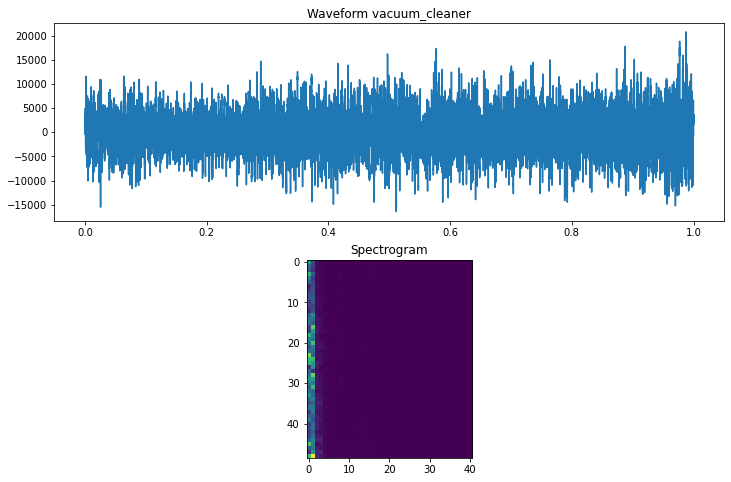

{'event_types': ['background', 'unknown', 'vacuum_cleaner'], 'total_event': {'background': 415, 'unknown': 408, 'vacuum_cleaner': 200}, 'train': {'background': 1, 'unknown': 1, 'vacuum_cleaner': 1}, 'test': {'background': 0, 'unknown': 0, 'vacuum_cleaner': 0}}


In [32]:
import sys
from random import shuffle
import pandas as pd
import wave
import numpy as np
import matplotlib.pyplot as plt
import shutil
import os
import argparse
import os.path
import sys

import tensorflow as tf

from speech_commands import input_data
from speech_commands import models

def get_features(sample_rate, clip_duration_ms, window_size_ms,
                    window_stride_ms, feature_bin_count, quantize, preprocess,
                    input_wav):
  """Converts an audio file into its corresponding feature map.

  Args:
    sample_rate: Expected sample rate of the wavs.
    clip_duration_ms: Expected duration in milliseconds of the wavs.
    window_size_ms: How long each spectrogram timeslice is.
    window_stride_ms: How far to move in time between spectrogram timeslices.
    feature_bin_count: How many bins to use for the feature fingerprint.
    quantize: Whether to train the model for eight-bit deployment.
    preprocess: Spectrogram processing mode; "mfcc", "average" or "micro".
    input_wav: Path to the audio WAV file to read.
  """

  # Start a new TensorFlow session.
  sess = tf.compat.v1.InteractiveSession()

  model_settings = models.prepare_model_settings(
      0, sample_rate, clip_duration_ms, window_size_ms, window_stride_ms,
      feature_bin_count, preprocess)
  audio_processor = input_data.AudioProcessor(None, None, 0, 0, '', 0, 0,
                                              model_settings, None)

  results = audio_processor.get_features_for_wav(input_wav, model_settings,
                                                 sess)
  features = results[0]
  return features

PATH = "D:\sound_dataset\environment"
RATIO = 0.8

event_types = ['background', 'unknown', 'vacuum_cleaner']
datastore_dict =dict()
datastore_dict["event_types"] = event_types
datastore_dict["total_event"] = dict()
datastore_dict["train"] = dict()
datastore_dict["test"] = dict()
for e in event_types:
    files = os.listdir("{}\\{}".format(PATH, e))
    shuffle(files)
    datastore_dict["total_event"][e] = len(files)
    datastore_dict["train"][e] = 0
    datastore_dict["test"][e] = 0
    for _f in files:
        f = "{}\\{}\\{}".format(PATH, e, _f)
        if datastore_dict["train"][e] < int(RATIO * datastore_dict["total_event"][e]):
            wav_obj = wave.open(f, 'rb')
            sample_freq = wav_obj.getframerate()
            n_samples = wav_obj.getnframes()
            t_audio = n_samples/sample_freq
            n_channels = wav_obj.getnchannels()
            signal_wave = wav_obj.readframes(n_samples)
            waveform = np.frombuffer(signal_wave, dtype=np.int16)
            features = get_features(sample_rate=sample_freq, clip_duration_ms=1000, window_size_ms=30, window_stride_ms=20, feature_bin_count=40, quantize=False, preprocess='average', input_wav=f)
            features = np.squeeze(features)
            print(features.shape)
            print(os.path.basename(f))
            fig, axes = plt.subplots(2, figsize=(12, 8))
            times = np.linspace(0, n_samples/sample_freq, num=n_samples)
            axes[0].plot(times, waveform)
            axes[0].set_title('Waveform {}'.format(e))

            axes[1].imshow(features, interpolation='none')
            axes[1].set_title('Spectrogram')
            plt.show()

            # times = np.linspace(0, n_samples/sample_freq, num=n_samples)
            # print(os.path.basename(f))
            # plt.figure(figsize=(15, 5))
            # plt.plot(times, signal_array)
            # plt.title('{}'.format(e))
            # plt.ylabel('Signal Value')
            # plt.xlabel('Time (s)')
            # plt.xlim(0, t_audio)
            # plt.show()
            datastore_dict["train"][e] += 1
            break
            
        else:
            datastore_dict["test"][e] += 1

print(datastore_dict)
